# Imports

In [3]:
import numpy as np
import os
import imutils
import dlib
import cv2
import imageio
from imutils import face_utils
import matplotlib.pyplot as plt
from IPython.display import Video
import random
import librosa
from moviepy.editor import *
from pytube import YouTube
from bs4 import BeautifulSoup
import json

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    return

# Find mouths in images

In [62]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [63]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

## Analyzing inference time

In [25]:
%%timeit

img = cv2.imread("images/matvey.jpg")
img = imutils.resize(img, width=500)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

197 ms ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit

rects = detector(img, 1)

300 ms ± 6.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit

shape = predictor(img, rects[0])
shape = shape_to_np(shape)
cv2.boundingRect(np.array([shape[48:68]]))

1.18 ms ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Trying different images

In [15]:
def find_mouths(img_path):
    img = cv2.imread(img_path)
    img = imutils.resize(img, width=500)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    rects = detector(img, 1)
    if len(rects) < 1:
        raise Exception("no faces detected")
        
    mouths = list()
    for (i, rect) in enumerate(rects):
        shape = predictor(img, rect)
        shape = shape_to_np(shape)
        mouths.append( cv2.boundingRect(np.array([shape[48:68]])) )  # (x,y,w,h)
    
    return img, mouths

In [17]:
%%timeit

find_mouths("images/matvey.jpg")

303 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
def show_mouths(img_path):
    img, mouths = find_mouths(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for mouth in mouths:
        x,y,w,h = mouth
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

    plt.figure()
    plt.imshow(img)

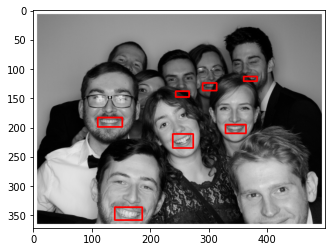

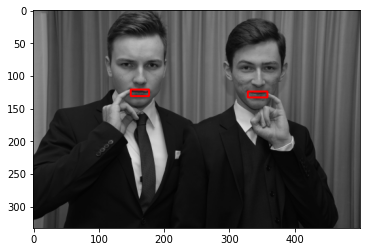

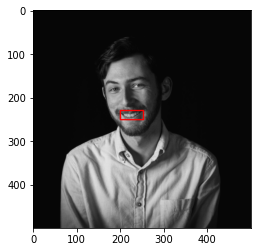

In [91]:
for img_name in os.listdir("images"):
    show_mouths("images/"+img_name)

# Find mouths in video

## With resizing

In [59]:
cap = cv2.VideoCapture('videos/test.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('videos/output1.mp4',fourcc, 23.98, (500,280))

while(cap.isOpened()):
    ret, img = cap.read()
    if ret == True:
        img = imutils.resize(img, width=500)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        rects = detector(img, 1)
        mouths = list()
        for (i, rect) in enumerate(rects):
            shape = predictor(img, rect)
            shape = shape_to_np(shape)
            mouths.append( cv2.boundingRect(np.array([shape[48:68]])) )  # (x,y,w,h)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        for mouth in mouths:
            x,y,w,h = mouth
            img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

        out.write(img)
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

## Without resizing

In [62]:
cap = cv2.VideoCapture('videos/test.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('videos/output2.mp4',fourcc, 23.98, (960,540))

while(cap.isOpened()):
    ret, img = cap.read()
    if ret == True:
        #img = imutils.resize(img, width=500)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        rects = detector(img, 1)
        mouths = list()
        for (i, rect) in enumerate(rects):
            shape = predictor(img, rect)
            shape = shape_to_np(shape)
            mouths.append( cv2.boundingRect(np.array([shape[48:68]])) )  # (x,y,w,h)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        for mouth in mouths:
            x,y,w,h = mouth
            img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

        out.write(img)
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

## Track speakers (via IOU)

In [1]:
from Box import Box

In [93]:
cap = cv2.VideoCapture('videos/test.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('videos/output3.mp4',fourcc, 23.98, (500,280))

recent_mouths = list()
frame_count = 0
while(cap.isOpened() and frame_count < 240):
    ret, img = cap.read()
    if ret == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = imutils.resize(img, width=500)
        rects = detector(img, 1)
        mouths = list()
        
        for (i, rect) in enumerate(rects):
            shape = predictor(img, rect)
            shape = shape_to_np(shape)
            mouths.append( cv2.boundingRect(np.array([shape[48:68]])) )  # (x,y,w,h)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        recent_mouths_temp = list()
        for mouth in mouths:
            x,y,w,h = mouth
            mouth_box = Box(x,y,x+w,y+h)
            for recent in recent_mouths:
                if mouth_box.getIOU(recent) > 0.1:
                    mouth_box.c = recent.c
                    break
            if mouth_box.c == None:
                mouth_box.c = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
                
            recent_mouths_temp.append(mouth_box)
            img = cv2.rectangle(img, (x,y), (x+w, y+h), mouth_box.c, 2)
        recent_mouths = recent_mouths_temp

        out.write(img)
        frame_count += 1
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

# SyncNet Pipeline

In [ ]:
def find_mouths_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    mouths = dict()
    frame_count = -1
    while(cap.isOpened()):
        ret, img = cap.read()
        if ret == True:
            frame_count += 1
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            orig_width = img.shape[1]
            resize_ratio = orig_width / 500
            img = imutils.resize(img, width=500)
            rects = detector(img, 1)
            if len(rects) != 1:
                continue
            rect = rects[0]
            shape = predictor(img, rect)
            shape = shape_to_np(shape)
            xywh = list(cv2.boundingRect(np.array([shape[48:68]])))
            mouths[frame_count] = [int(x * resize_ratio) for x in xywh]
        else:
            break
    cap.release()
    return mouths

In [ ]:
mouths = find_mouths_in_video("/home/fridman/SyncNet/DATA/videos/FQDniBcyntc.mp4")
mouths

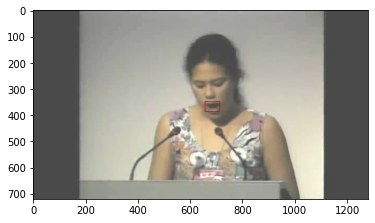

In [92]:
frame = 380
cap = cv2.VideoCapture("/home/fridman/SyncNet/DATA/videos/FQDniBcyntc.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

x,y,w,h = mouths[frame]
x = int(x)
y = int(y)
w = int(w)
h = int(h)
img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

plt.imshow(img)

# Audio Shenanigans

In [4]:
video = VideoFileClip("/home/fridman/SyncNet/DATA/videos/j-6zwv31qjg.mp4")
audio = video.audio
video.fps
#audio.write_audiofile("/home/fridman/SyncNet/lol.wav")
#clear_output()

30.0

In [6]:
start = 69
start_sec = start / video.fps
end_sec = (start + 5) / video.fps
audio = audio.set_start(start_sec, change_end=False)
audio = audio.set_end(end_sec)
audio.duration

0.16666666666666696

In [42]:
lol = librosa.load("/home/fridman/SyncNet/lol.wav", sr=48000)
lol

(array([ 0.        ,  0.        ,  0.        , ..., -0.00027505,
        -0.00036036, -0.00031191], dtype=float32),
 48000)

In [44]:
lol = lol[0]
lol.shape

(34426560,)

In [39]:
lol2 = audio.to_soundarray(fps=48000)
lol2

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-0.00085449,  0.00076294],
       [-0.00085449,  0.00067139],
       [-0.00085449,  0.00057983]])

In [48]:
lol2.T.shape

(2, 34426560)

In [49]:
lol3 = (lol2.T[0]+lol2.T[1])/2
lol3.shape

(34426560,)